In [ ]:
import os, glob, math, random
from typing import List, Tuple
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend as K

In [2]:
# =========================
# USER CONFIG: YOUR PATHS
# =========================
PUBLIC_IMAGES = r"C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-seg\Kvasir-SEG\images"
PUBLIC_MASKS  = r"C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-seg\Kvasir-SEG\masks"
CUSTOM_IMAGES = r"C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-sessile\sessile-main-Kvasir-SEG\images"
CUSTOM_MASKS  = r"C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-sessile\sessile-main-Kvasir-SEG\masks"


In [69]:
OUTPUT_DIR = r"C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-sessile\outputs_final"
PRED_DIR   = os.path.join(OUTPUT_DIR, "pred_masks")
FIGURE_DIR = os.path.join(OUTPUT_DIR, "figures_xai")
FIGURE_DIR_1 = os.path.join(OUTPUT_DIR, "figures_xai-1")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PRED_DIR, exist_ok=True)
os.makedirs(FIGURE_DIR, exist_ok=True)


In [4]:
# =========================
# TRAINING CONFIG
# =========================
IMG_H, IMG_W = 224, 224
BATCH_SIZE = 4
LR_PRETRAIN = 2e-4
LR_FINETUNE = 1e-4
PRETRAIN_EPOCHS = 10      # on public Kvasir-SEG
FINETUNE_EPOCHS = 30      # on Sessile-Main-Kvasir-SEG
THRESH = 0.5
SEED = 42

random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


In [5]:
# =========================
# UTIL: pair images & masks
# =========================
def find_image_mask_pairs(img_dir: str, mask_dir: str) -> List[Tuple[str,str]]:
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff")
    imgs, masks = [], []
    for e in exts:
        imgs  += glob.glob(os.path.join(img_dir, e))
        masks += glob.glob(os.path.join(mask_dir, e))
    # map by basename (without extension)
    imap = {os.path.splitext(os.path.basename(p))[0]: p for p in imgs}
    mmap = {os.path.splitext(os.path.basename(p))[0]: p for p in masks}
    keys = sorted(set(imap.keys()) & set(mmap.keys()))
    return [(imap[k], mmap[k]) for k in keys]

In [6]:
def read_pair(img_path: str, msk_path: str):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
    if msk is None:
        raise FileNotFoundError(f"Mask not found: {msk_path}")
    return img, msk

In [7]:
# =========================
# DATA SEQUENCE (no aug)
# =========================
class SegSequence(keras.utils.Sequence):
    def __init__(self, pairs, batch_size=8, shuffle=True):
        self.pairs = list(pairs)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    def __len__(self): return math.ceil(len(self.pairs)/self.batch_size)
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.pairs))
        if self.shuffle: np.random.shuffle(self.indexes)
    def __getitem__(self, idx):
        inds = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        X, Y = [], []
        for i in inds:
            img_path, msk_path = self.pairs[i]
            img, msk = read_pair(img_path, msk_path)
            img = cv2.resize(img, (IMG_W, IMG_H)).astype(np.float32)/255.0
            msk = cv2.resize(msk, (IMG_W, IMG_H))
            msk = (msk > 127).astype(np.float32)[..., None]
            X.append(img); Y.append(msk)
        return np.stack(X, 0), np.stack(Y, 0)

In [8]:
# =========================
# MODEL: U-Net MobileNetV2
# =========================
def conv_bn_relu(x, f, k=3):
    x = layers.Conv2D(f, k, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

In [9]:
def build_unet_mobilenetv2(input_shape=(IMG_H, IMG_W, 3)):
    base = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=input_shape)
    # Skips from MobileNetV2
    s1 = base.get_layer("block_1_expand_relu").output   # 128x128
    s2 = base.get_layer("block_3_expand_relu").output   # 64x64
    s3 = base.get_layer("block_6_expand_relu").output   # 32x32
    s4 = base.get_layer("block_13_expand_relu").output  # 16x16
    b  = base.get_layer("block_16_project").output      # 8x8 (bottleneck)

    # Decoder
    x = layers.Conv2DTranspose(256, 2, strides=2, padding="same")(b)  # 16x16
    x = layers.Concatenate()([x, s4]); x = conv_bn_relu(x, 256); x = conv_bn_relu(x, 256)

    x = layers.Conv2DTranspose(128, 2, strides=2, padding="same")(x)  # 32x32
    x = layers.Concatenate()([x, s3]); x = conv_bn_relu(x, 128); x = conv_bn_relu(x, 128)

    x = layers.Conv2DTranspose(64, 2, strides=2, padding="same")(x)   # 64x64
    x = layers.Concatenate()([x, s2]); x = conv_bn_relu(x, 64);  x = conv_bn_relu(x, 64)

    x = layers.Conv2DTranspose(32, 2, strides=2, padding="same")(x)   # 128x128
    x = layers.Concatenate()([x, s1]); x = conv_bn_relu(x, 32);  x = conv_bn_relu(x, 32)

    x = layers.Conv2DTranspose(16, 2, strides=2, padding="same")(x)   # 256x256
    x = conv_bn_relu(x, 16); x = conv_bn_relu(x, 16)

    logits = layers.Conv2D(1, 1, name="logits")(x)
    out = layers.Activation("sigmoid", name="mask")(logits)

    model = keras.Model(inputs=base.input, outputs=out, name="UNet_MobileNetV2")
    return model, base

In [10]:
# =========================
# LOSSES & METRICS
# =========================
def dice_coeff_tf(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true); y_pred_f = K.flatten(y_pred)
    inter = K.sum(y_true_f * y_pred_f)
    return (2.*inter + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_tf(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true); y_pred_f = K.flatten(y_pred)
    inter = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

def precision_tf(y_true, y_pred, eps=1e-6):
    y_pred_bin = K.cast(y_pred > THRESH, "float32")
    tp = K.sum(y_pred_bin * y_true)
    fp = K.sum(y_pred_bin * (1 - y_true))
    return (tp + eps) / (tp + fp + eps)

def recall_tf(y_true, y_pred, eps=1e-6):
    y_pred_bin = K.cast(y_pred > THRESH, "float32")
    tp = K.sum(y_pred_bin * y_true)
    fn = K.sum((1 - y_pred_bin) * y_true)
    return (tp + eps) / (tp + fn + eps)

def f1_tf(y_true, y_pred):
    p = precision_tf(y_true, y_pred); r = recall_tf(y_true, y_pred)
    return 2.0 * p * r / (p + r + 1e-6)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + (1.0 - dice_coeff_tf(y_true, y_pred))

In [11]:
# =========================
# PREP DATA
# =========================
for p in (PUBLIC_IMAGES, PUBLIC_MASKS, CUSTOM_IMAGES, CUSTOM_MASKS):
    if not os.path.isdir(p): print(f"[WARN] Missing: {p}")

public_pairs = find_image_mask_pairs(PUBLIC_IMAGES, PUBLIC_MASKS)
custom_pairs = find_image_mask_pairs(CUSTOM_IMAGES, CUSTOM_MASKS)
print(f"Found public pairs: {len(public_pairs)} | custom pairs: {len(custom_pairs)}")


Found public pairs: 1000 | custom pairs: 196


In [12]:
# Public split 90/10
if len(public_pairs) > 0:
    random.shuffle(public_pairs)
    n_pub = len(public_pairs); ntr_pub = int(0.9*n_pub)
    pub_train_pairs = public_pairs[:ntr_pub]
    pub_val_pairs   = public_pairs[ntr_pub:]
    pub_train_seq = SegSequence(pub_train_pairs, batch_size=BATCH_SIZE, shuffle=True)
    pub_val_seq   = SegSequence(pub_val_pairs,   batch_size=BATCH_SIZE, shuffle=False)
else:
    pub_train_seq = pub_val_seq = None

In [13]:
# Custom split 70/10/20
random.shuffle(custom_pairs)
n_cus = len(custom_pairs)
n_train = int(0.7 * n_cus)
n_val   = int(0.1 * n_cus)
train_pairs = custom_pairs[:n_train]
val_pairs   = custom_pairs[n_train:n_train+n_val]
test_pairs  = custom_pairs[n_train+n_val:]

cus_train_seq = SegSequence(train_pairs, batch_size=BATCH_SIZE, shuffle=True)
cus_val_seq   = SegSequence(val_pairs,   batch_size=BATCH_SIZE, shuffle=False)


In [14]:
# =========================
# BUILD & TRAIN
# =========================
model, encoder = build_unet_mobilenetv2(input_shape=(IMG_H, IMG_W, 3))
opt = keras.optimizers.Adam(LR_PRETRAIN)
model.compile(optimizer=opt, loss=bce_dice_loss,
              metrics=[dice_coeff_tf, iou_tf, precision_tf, recall_tf, f1_tf])
model.summary()

Model: "UNet_MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 5,578,433 (21.28 MB)

 Trainable params: 5,545,537 (21.15 MB)

 Non-trainable params: 32,896 (128.50 KB)

In [15]:
# Callbacks
ckpt_path = os.path.join(OUTPUT_DIR, "best_model.keras")
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_dice_coeff_tf", save_best_only=True, mode="max", verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_dice_coeff_tf", mode="max", factor=0.5, patience=4, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_dice_coeff_tf", mode="max", patience=10, restore_best_weights=True, verbose=1),
]

In [16]:
# Pretraining on public (freeze encoder)
if pub_train_seq is not None:
    print("\n>>> Pretraining on public Kvasir-SEG (encoder frozen)")
    for l in encoder.layers: l.trainable = False
    model.compile(optimizer=keras.optimizers.Adam(LR_PRETRAIN), loss=bce_dice_loss,
                  metrics=[dice_coeff_tf, iou_tf, precision_tf, recall_tf, f1_tf])
    model.fit(pub_train_seq,
          validation_data=pub_val_seq,
          epochs=PRETRAIN_EPOCHS,
          callbacks=[keras.callbacks.ReduceLROnPlateau(
              monitor="val_dice_coeff_tf", mode="max",
              factor=0.5, patience=3, verbose=1)],
          verbose=1)

else:
    print("\n[INFO] No public dataset found -> skipping pretraining.")



>>> Pretraining on public Kvasir-SEG (encoder frozen)
Epoch 1/10


C:\Users\Berhanu pc\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 151s 619ms/step - dice_coeff_tf: 0.5015 - f1_tf: 0.6740 - iou_tf: 0.3448 - loss: 0.8030 - precision_tf: 0.6437 - recall_tf: 0.7587 - val_dice_coeff_tf: 0.5897 - val_f1_tf: 0.7637 - val_iou_tf: 0.4248 - val_loss: 0.6399 - val_precision_tf: 0.7366 - val_recall_tf: 0.8238 - learning_rate: 2.0000e-04
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 144s 642ms/step - dice_coeff_tf: 0.6306 - f1_tf: 0.7786 - iou_tf: 0.4687 - loss: 0.5710 - precision_tf: 0.7670 - recall_tf: 0.8389 - val_dice_coeff_tf: 0.6888 - val_f1_tf: 0.8114 - val_iou_tf: 0.5327 - val_loss: 0.4672 - val_precision_tf: 0.8333 - val_recall_tf: 0.8045 - learning_rate: 2.0000e-04
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 136s 606ms/step - dice_coeff_tf: 0.6969 - f1_tf: 0.8189 - iou_tf: 0.5423 - loss: 0.4692 - precision_tf: 0.8143 - recall_tf: 0.8579 - val_dice_coeff_tf: 0.7200 - val_f1_tf: 0.7774 - val_iou_tf: 0.5689 - val_loss: 0.5018 - val_precision_tf: 0.7040 - val_recall_tf: 0.8935 - learning_rate: 2.0000e-

In [17]:
# Fine-tuning on custom (unfreeze all)
print("\n>>> Fine-tuning on Sessile-Main-Kvasir-SEG (encoder unfrozen)")
for l in model.layers: l.trainable = True
model.compile(optimizer=keras.optimizers.Adam(LR_FINETUNE), loss=bce_dice_loss,
              metrics=[dice_coeff_tf, iou_tf, precision_tf, recall_tf, f1_tf])



>>> Fine-tuning on Sessile-Main-Kvasir-SEG (encoder unfrozen)


In [18]:
print(">>> Fine-tuning on custom dataset")
history = model.fit(cus_train_seq,
                    validation_data=cus_val_seq,
                    epochs=FINETUNE_EPOCHS,
                    callbacks=callbacks, verbose=1)

>>> Fine-tuning on custom dataset
Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - dice_coeff_tf: 0.5779 - f1_tf: 0.6217 - iou_tf: 0.4262 - loss: 0.7133 - precision_tf: 0.5646 - recall_tf: 0.7705
Epoch 1: val_dice_coeff_tf improved from None to 0.62511, saving model to C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-sessile\outputs_final\best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - dice_coeff_tf: 0.6389 - f1_tf: 0.6939 - iou_tf: 0.4865 - loss: 0.5657 - precision_tf: 0.6771 - recall_tf: 0.7732 - val_dice_coeff_tf: 0.6251 - val_f1_tf: 0.6923 - val_iou_tf: 0.4709 - val_loss: 0.4589 - val_precision_tf: 0.9676 - val_recall_tf: 0.5696 - learning_rate: 1.0000e-04
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - dice_coeff_tf: 0.7914 - f1_tf: 0.8606 - iou_tf: 0.6621 - loss: 0.2814 - precision_tf: 0.8786 - recall_tf: 0.8586
Epoch 2: val_dice_coeff_tf did not improve from 0.62511
35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 963ms/step - dice_coeff_tf: 0.7770 

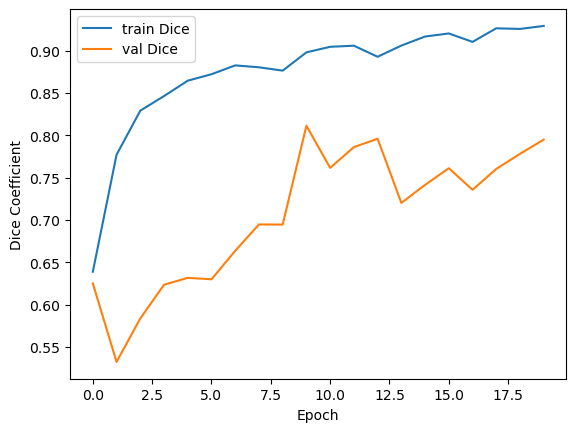

In [83]:
import matplotlib.pyplot as plt

plt.plot(history.history['dice_coeff_tf'], label='train Dice')
plt.plot(history.history['val_dice_coeff_tf'], label='val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [59]:
# Load best model if saved
if os.path.exists(ckpt_path):
    print("Loading best model:", ckpt_path)
    model = keras.models.load_model(ckpt_path, compile=False)
    model.compile(optimizer=keras.optimizers.Adam(LR_FINETUNE), loss=bce_dice_loss,
                  metrics=[dice_coeff_tf, iou_tf, precision_tf, recall_tf, f1_tf])

Loading best model: C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-sessile\outputs_final\best_model.keras


In [20]:
# =========================
# EVALUATION on TEST (per-image + mean)
# =========================
def bin_metrics_from_arrays(pred_bin, gt_bin):
    tp = np.sum((pred_bin == 1) & (gt_bin == 1))
    tn = np.sum((pred_bin == 0) & (gt_bin == 0))
    fp = np.sum((pred_bin == 1) & (gt_bin == 0))
    fn = np.sum((pred_bin == 0) & (gt_bin == 1))
    iou = tp / (tp + fp + fn + 1e-6)
    dice = (2*tp) / (2*tp + fp + fn + 1e-6)
    prec = tp / (tp + fp + 1e-6)
    rec  = tp / (tp + fn + 1e-6)
    f1   = (2*prec*rec) / (prec + rec + 1e-6)
    acc  = (tp + tn) / (tp + tn + fp + fn + 1e-6)
    return iou, dice, prec, rec, f1, acc

In [21]:
rows = []
print("\nRunning predictions on TEST and computing per-image metrics...")
for img_path, msk_path in tqdm(test_pairs, desc="Test"):
    img, msk = read_pair(img_path, msk_path)
    img_r = cv2.resize(img, (IMG_W, IMG_H)).astype(np.float32)/255.0
    msk_r = cv2.resize(msk, (IMG_W, IMG_H))
    pred = model.predict(img_r[None, ...], verbose=0)[0, ..., 0]
    pred_bin = (pred > THRESH).astype(np.uint8)
    gt_bin = (msk_r > 127).astype(np.uint8)

    iou, dice, prec, rec, f1, acc = bin_metrics_from_arrays(pred_bin, gt_bin)

    # save predicted binary mask
    stem = os.path.splitext(os.path.basename(img_path))[0]
    cv2.imwrite(os.path.join(PRED_DIR, f"{stem}_pred.png"), (pred_bin*255).astype(np.uint8))

    rows.append({"image": os.path.basename(img_path), "iou": iou, "dice": dice,
                 "precision": prec, "recall": rec, "f1": f1, "accuracy": acc})



Running predictions on TEST and computing per-image metrics...


Test: 100%|████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.65it/s]


In [22]:
df = pd.DataFrame(rows)
csv_path = os.path.join(OUTPUT_DIR, "test_metrics.csv")
df.to_csv(csv_path, index=False)
print("Per-image metrics saved to:", csv_path)
print("Mean metrics:\n", df[["iou","dice","precision","recall","f1","accuracy"]].mean())


Per-image metrics saved to: C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-sessile\outputs_final\test_metrics.csv
Mean metrics:
 iou          0.730934
dice         0.817694
precision    0.896582
recall       0.789400
f1           0.817694
accuracy     0.969125
dtype: float64


In [23]:
# =========================
# Grad-CAM for segmentation
# =========================
def get_last_conv_layer_name(m):
    # prefer last Conv2D layer (decoder side)
    for layer in reversed(m.layers):
        if isinstance(layer, layers.Conv2D):
            return layer.name
    # fallback: any layer with 'conv' in name
    for layer in reversed(m.layers):
        if 'conv' in layer.name.lower():
            return layer.name
    return None

In [24]:
def gradcam_for_seg(model, img_tensor, last_conv_layer_name=None):
    # img_tensor: (1,H,W,3) float32 [0..1]
    if last_conv_layer_name is None:
        last_conv_layer_name = get_last_conv_layer_name(model)
    grad_model = keras.models.Model([model.inputs],
                                    [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outs, preds = grad_model(img_tensor)
        # scalar target: mean of predicted mask
        target = tf.reduce_mean(preds)
    grads = tape.gradient(target, conv_outs)[0]        # HxWxC
    weights = tf.reduce_mean(grads, axis=(0,1))        # C
    cam = tf.reduce_sum(conv_outs[0] * weights, axis=-1)
    cam = tf.nn.relu(cam)
    cam = cam.numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam

In [25]:
# =========================
# XAI: save N samples with 5 panels
# =========================
def save_xai_results(model, pairs, n_samples=6, save_dir=FIGURE_DIR):
    if len(pairs) == 0:
        print("[WARN] No pairs to visualize.")
        return
    n_samples = min(n_samples, len(pairs))
    chosen = random.sample(pairs, n_samples)
    for idx, (img_path, mask_path) in enumerate(chosen, start=1):
        # read originals
        img, msk = read_pair(img_path, mask_path)
        H0, W0 = img.shape[:2]

        # preprocess
        img_res = cv2.resize(img, (IMG_W, IMG_H)).astype(np.float32)/255.0
        inp = img_res[None, ...]

        # predict
        prob = model.predict(inp, verbose=0)[0, ..., 0]              # (H,W)
        pred_bin = (prob > THRESH).astype(np.uint8)

        # grad-cam
        heat = gradcam_for_seg(model, inp, last_conv_layer_name=None)  # (H,W) [0..1]
        # resize to original for nicer figs
        prob_vis = cv2.resize(prob, (W0, H0))
        pred_vis = cv2.resize(pred_bin*255, (W0, H0))
        gt_vis   = cv2.resize(msk, (W0, H0))
        heat_res = cv2.resize(heat, (W0, H0))
        # colorize prob and heat
        prob_uint8 = (prob_vis*255).astype(np.uint8)
        prob_color = cv2.applyColorMap(prob_uint8, cv2.COLORMAP_VIRIDIS)  # soft probability
        heat_uint8 = (heat_res*255).astype(np.uint8)
        heat_color = cv2.applyColorMap(heat_uint8, cv2.COLORMAP_JET)

        # overlays
        gt_overlay   = img.copy()
        gt_overlay   = cv2.addWeighted(gt_overlay, 0.7, cv2.cvtColor(gt_vis, cv2.COLOR_GRAY2RGB), 0.3, 0)
        pred_overlay = img.copy()
        pred_overlay = cv2.addWeighted(pred_overlay, 0.7, cv2.cvtColor(pred_vis, cv2.COLOR_GRAY2RGB), 0.3, 0)
        gradcam_overlay = cv2.addWeighted(img, 0.6, cv2.cvtColor(heat_color, cv2.COLOR_BGR2RGB), 0.4, 0)

        # plot 5 panels
        plt.figure(figsize=(16, 6))
        plt.subplot(1,5,1); plt.imshow(img); plt.title("Input"); plt.axis("off")
        plt.subplot(1,5,2); plt.imshow(gt_overlay); plt.title("GT Mask (overlay)"); plt.axis("off")
        plt.subplot(1,5,3); plt.imshow(pred_overlay); plt.title(f"Prediction (thr {THRESH})"); plt.axis("off")
        plt.subplot(1,5,4); plt.imshow(cv2.cvtColor(prob_color, cv2.COLOR_BGR2RGB)); plt.title("Probability Map"); plt.axis("off")
        plt.subplot(1,5,5); plt.imshow(gradcam_overlay); plt.title("Grad-CAM Overlay"); plt.axis("off")
        out_path = os.path.join(save_dir, f"xai_{idx}.png")
        plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.close()
    print(f"✅ Saved {n_samples} XAI figures to: {save_dir}")

In [26]:
# save 6 XAI examples from TEST split
save_xai_results(model, test_pairs, n_samples=6, save_dir=FIGURE_DIR)

print("\nPipeline complete.")
print("Outputs:")
print(" • Test metrics CSV:", os.path.join(OUTPUT_DIR, "test_metrics.csv"))
print(" • Predicted masks :", PRED_DIR)
print(" • XAI figures     :", FIGURE_DIR)

C:\Users\Berhanu pc\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


✅ Saved 6 XAI figures to: C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-sessile\outputs_final\figures_xai

Pipeline complete.
Outputs:
 • Test metrics CSV: C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-sessile\outputs_final\test_metrics.csv
 • Predicted masks : C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-sessile\outputs_final\pred_masks
 • XAI figures     : C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-sessile\outputs_final\figures_xai
